# Access CZI-maintained embeddings (scVI, Geneformer)

This notebook demonstrates basic access to CZI-maintained embeddings of the Census. Currently, embeddings from scVI and a fine-tuned flavor of Geneformer are maintained by CELLxGENE Discover. There are other community-contributed embeddings hosted by CELLxGENE Discvoer,find out more about these in the Census model page [TODO insert link]

**Contents**

1. Quick start
1. Storage format
1. Query cells and load associated embeddings

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).


## Quick start

CZI-maintained embeddings are encoded in the `obsm` slot of selected Census versions so you can easily export them into an AnnData as shown below for any slice of Census, in this examples cells from tongue tissue. 

⚠️ Note that Geneformer embeddings are only available for human data

In [1]:
import cellxgene_census
import warnings
warnings.filterwarnings('ignore')

# START: REMOVE
import tiledbsoma
config = {
    "vfs.s3.region": "us-west-2",
    "py.init_buffer_bytes": 1 * 1024**3,
    "soma.init_buffer_bytes": 1 * 1024**3,
}

ctx = tiledbsoma.options.SOMATileDBContext()
ctx = ctx.replace(tiledb_config=config)
# END: REMOVE


emb_names = ["scvi", "geneformer"]
emb_names = ["scvi"]
census_version = "2023-10-23"

#with cellxgene_census.open_soma(census_version=census_version):
with cellxgene_census.open_soma(uri="s3://bruce-tmp/emb-build-2023-12-10/2023-10-23/soma/", context=ctx) as census:
    adata = cellxgene_census.get_anndata(
        census,
        organism = "homo_sapiens",
        measurement_name = "RNA",
        obs_value_filter = "tissue == 'tongue'",
        obsm_layers = emb_names
    )

In [2]:
adata

AnnData object with n_obs × n_vars = 372 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi'

In [3]:
adata.obsm

AxisArrays with keys: scvi

## Storage format

Each embedding is encoded as a SOMA SparseNDArray under `obsm` of an organism's SOMA Experiment, where:

* dimension 0 (`soma_dim_0`) encodes the cell (obs) `soma_joinid` value
* dimension 1 (`soma_dim_1`) encodes the embedding feature, and is in the range [0, N) where N is the number of featues in the embedding
* data (`soma_data`) is float32

The first axis of the embedding array will have the same shape as the corresponding `obs` DataFrame for the Census build and experiment. The second axis of the embedding will have a shape (0, N) where N is the number of features in the embedding.

Embedding values, while stored as a float32, are precision reduced. Currently they are equivalent to a bfloat16, i.e., have 8 bits of exponent and 7 bits of mantissa.

## Query cells and load associated embeddings

This section demonstrates several methods to query cells from the Census by `obs` metadata, and then fetch embeddings associated with each cell.

### Loading embeddings into a Scipy matrices and NumPy arrays

This section demonstrates how to get embedings for a slice of census directly into Scipy sparse matrices or NumPy arrays.

We demonstrate this access pattern by a lazy query via `ExperimentAxisQuery`. As a reminder this class offers a lazy interface to query Census based on cell and gene metadata, and provides access to the correspondong expression data, cell/gene metadata, and the embeddings.

First we open a handle to Census.

In [4]:
import cellxgene_census
import scipy
import tiledbsoma as soma

census_version = "2023-10-23"
#census = cellxgene_census.open_soma(census_version=census_version)
census = cellxgene_census.open_soma(uri="s3://bruce-tmp/emb-build-2023-12-10/2023-10-23/soma/", context=ctx)

Then que initiate a query to create an `ExperimentAxisQuery`. In this example we will query for all human cells of `tissue_general` equal to `'central nervous system'`.

In [5]:
experiment = census["census_data"]["homo_sapiens"]
query = experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter="tissue_general == 'central nervous system'")
)

And now we can access any of the following:

- Expression data via the method `query.X()`.
- Cell and gene metadata via the mehtods `query.obs()` and `query.var()`, respectively.
- The cell embeddings via the method `query.obsm()`.

The method `query.obsm()` returns a reader class `soma.SparseNDArrayRead`, which in turns can return different types of iterators. In this case we will use a `blockwise.scipy()` iterator that guarantees full re-indexed rows in scipy sparse csr format.

In [6]:
emb_iter = query.obsm(layer="scvi").blockwise(axis=0).scipy()

Each iteration on `emb_iter` would return a tuple of size 3 with the following elements:

1. The scipy sparse matrix for this iteration.
2. The `soma_joinid` values for the rows (cells).
3. The `soma_joinid` values for the columns (genes).

Thus if we'd like to concatenate all of the resulting sparse matrices we can do the following:

In [7]:
emb=scipy.sparse.vstack([chunk[0] for chunk in emb_iter])

An now we have an sparse matrix with the embedding data.

In [8]:
emb

<31780x200 sparse matrix of type '<class 'numpy.float32'>'
	with 6356000 stored elements in Compressed Sparse Row format>

Which can be easily converted to a numpy array.

In [9]:
emb=emb.toarray()
emb

array([[ 3.9672852e-03,  1.2878418e-02,  4.8632812e-01, ...,
        -3.5742188e-01, -3.0664062e-01, -1.3198853e-03],
       [ 2.5390625e-02,  5.9814453e-03,  5.5078125e-01, ...,
        -1.6015625e-01, -1.0000000e+00,  3.6132812e-01],
       [ 1.0070801e-03,  1.9165039e-02,  5.4296875e-01, ...,
         3.9648438e-01, -9.8828125e-01,  1.1796875e+00],
       ...,
       [-3.7109375e-02,  2.3315430e-02,  7.8125000e-02, ...,
        -7.6953125e-01,  1.4218750e+00,  2.4316406e-01],
       [-1.2756348e-02,  3.1494141e-02,  4.2187500e-01, ...,
        -9.4140625e-01,  1.7890625e+00, -1.1484375e+00],
       [-2.9663086e-02, -6.2942505e-04,  4.4531250e-01, ...,
         3.6315918e-03,  8.4765625e-01, -7.2656250e-01]], dtype=float32)

In [10]:
emb.shape

(31780, 200)

And we can then load the corresponding expression data or the metadata. In this example we retrieve the cell types for all cells in this slice.

In [11]:
query.obs(column_names = ["cell_type"]).concat().to_pandas()

,cell_type,tissue_general
0,ependymal cell,central nervous system
1,astrocyte,central nervous system
2,astrocyte,central nervous system
3,astrocyte,central nervous system
4,astrocyte,central nervous system
...,...,...
31775,oligodendrocyte,central nervous system
31776,oligodendrocyte,central nervous system
31777,oligodendrocyte,central nervous system
31778,oligodendrocyte,central nervous system


In [12]:
query.close()
census.close()

### Loading embeddings into an AnnData

There are two main ways to load CZI-maintained embeddings into an AnnData.

1. Via `cellxgene_census.get_anndata()`.
2. With a lazy query via `ExperimentAxisQuery`.

#### AnnData embeddings via `cellxgene_census.get_anndata()`

This is the simplest way of getting the embeddings. In this example we create an AnnData for all central nervous system cells

In [13]:
import cellxgene_census
import scanpy

census_version = "2023-10-23"
#census = cellxgene_census.open_soma(census_version=census_version)
census = cellxgene_census.open_soma(uri="s3://bruce-tmp/emb-build-2023-12-10/2023-10-23/soma/", context=ctx)

emb_names = ["scvi", "geneformer"]
emb_names = ["scvi"]

adata = cellxgene_census.get_anndata(
    census,
    organism = "homo_sapiens",
    measurement_name = "RNA",
    obs_value_filter = "tissue_general == 'central nervous system'",
    column_names={"obs": ["cell_type"]},
    obsm_layers = emb_names,
)

census.close()

Then we can take a quick look at the embeddings in a 2D scatter plot via UMAP.

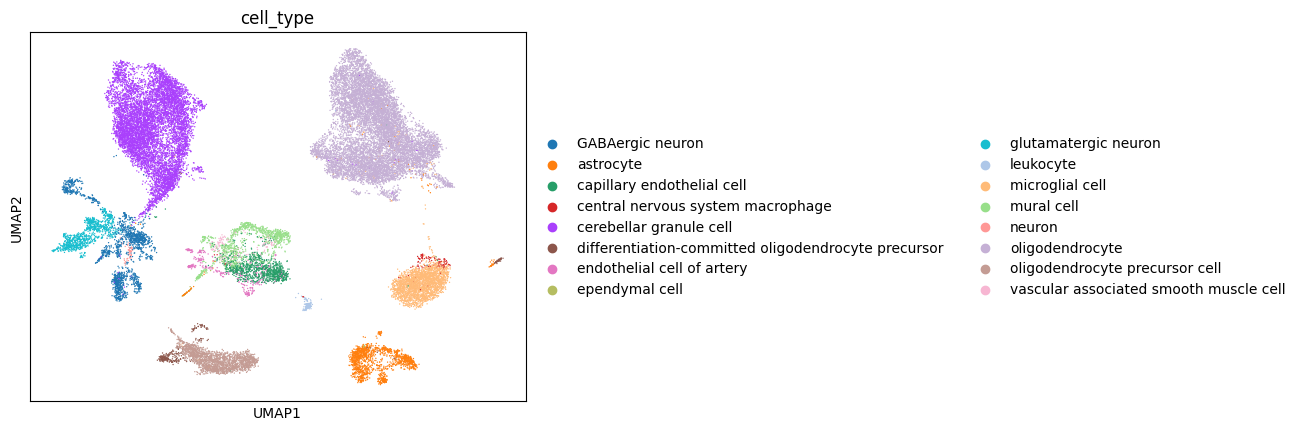

In [14]:
scanpy.pp.neighbors(adata, use_rep="scvi")
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color="cell_type")

#### AnnData embeddings via `ExperimentAxisQuery`

Using an `ExperimentAxisQuery` to get embeddings into an AnnData has the main advantage of inspecting the query in a lazy manner before loading all data into AnnData.

Let's initiate an identical query as the previous example.

In [15]:
import cellxgene_census
import scanpy

census_version = "2023-10-23"
#census = cellxgene_census.open_soma(census_version=census_version)
census = cellxgene_census.open_soma(uri="s3://bruce-tmp/emb-build-2023-12-10/2023-10-23/soma/", context=ctx)
experiment = census["census_data"]["homo_sapiens"]
query = experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter="tissue_general == 'central nervous system'")
)

Now we can take a look at different attributes, for example the number of cells in our query.

In [16]:
query.n_obs

31780

And then create an AnnData.

In [17]:
emb_names = ["scvi", "geneformer"]
emb_names = ["scvi"]

adata = query.to_anndata(
    X_name = "raw",
    obsm_layers=emb_names,
    column_names={"obs": ["cell_type"]}
)

In [18]:
adata

AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi'